# Mayo Classification with ResNet50

In [1]:
import torch

device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")

Training on GPU


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Training part

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import numpy as np

# Image data directories
train_dir = '/content/drive/MyDrive/train_and_validation_sets'  # Replace with actual path
test_dir = '/content/drive/MyDrive/test_set'  # Replace with actual path

# Hyperparameters
batch_size = 32
num_classes = 4
learning_rate = 0.001
num_epochs = 10


In [4]:
# Transformations for training data
train_transforms = transforms.Compose([
    transforms.Resize(256),  # Resize to a larger size
    transforms.RandomResizedCrop(224),  # Randomly crop to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet
])

# Transformations for test data
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize based on ImageNet
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [5]:
# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)


# Final Layer Modification
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# To deal with the imbalanced problem, calculate class weights for criterion

from sklearn.utils import class_weight
labels_arr = [label.item() for _,labels in train_loader for label in labels]
weight = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(labels_arr), y=labels_arr)
class_weights=torch.tensor(weight,dtype=torch.float).to(device)

In [7]:
# Define loss function, optimizer, and scheduler (optional)
from tqdm import tqdm

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
for epoch in range(num_epochs):
    # Train loop
    training_loss = 0.0
    correct = 0
    model.train()

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(labels.view_as(prediction)).sum().item()
        training_loss += loss.item()

    training_loss /= len(train_loader)
    correct /= len(train_loader.dataset)
    print(f'Epoch:{epoch},Training loss:{training_loss},Correct Samples:{correct}')


100%|██████████| 300/300 [01:16<00:00,  3.94it/s]


Epoch:0,Training loss:1.2020145306984584,Correct Samples:0.5241918665276329


100%|██████████| 300/300 [01:15<00:00,  3.97it/s]


Epoch:1,Training loss:1.0073182115952173,Correct Samples:0.5933263816475496


100%|██████████| 300/300 [01:15<00:00,  3.95it/s]


Epoch:2,Training loss:0.9167228366931279,Correct Samples:0.6305526590198123


100%|██████████| 300/300 [01:16<00:00,  3.95it/s]


Epoch:3,Training loss:0.8781211276849111,Correct Samples:0.6473409801876955


100%|██████████| 300/300 [01:15<00:00,  3.98it/s]


Epoch:4,Training loss:0.8624353398879369,Correct Samples:0.656830031282586


100%|██████████| 300/300 [01:15<00:00,  3.99it/s]


Epoch:5,Training loss:0.8529567189017931,Correct Samples:0.6645464025026069


100%|██████████| 300/300 [01:15<00:00,  3.99it/s]


Epoch:6,Training loss:0.8139743177096049,Correct Samples:0.6840458811261731


100%|██████████| 300/300 [01:15<00:00,  3.96it/s]


Epoch:7,Training loss:0.7996914041042328,Correct Samples:0.6852971845672575


100%|██████████| 300/300 [01:15<00:00,  3.99it/s]


Epoch:8,Training loss:0.800291121105353,Correct Samples:0.6922836287799792


100%|██████████| 300/300 [01:15<00:00,  3.99it/s]

Epoch:9,Training loss:0.7818378260731698,Correct Samples:0.6938477580813347


In [8]:
import torch
torch.save(model, 'resnet50.pth')

 # Evaluation

In [9]:
# Evaluation of the model, taken from https://github.com/GorkemP/labeled-images-for-ulcerative-colitis
model.eval()
val_loss = 0.0
correct = 0
y_true = []
y_pred = []
y_probs = []

# Obtain predicted labels and true labels as a list
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    y_true.append(target.item())

    output = model(data)
    y_probs.append(output.softmax(1).tolist()[0])
    prediction = output.argmax(dim=1, keepdim=True)[0][0].item()
    y_pred.append(prediction)

In [10]:
# Confusion Matrix
def confusion_matrix(test_labels,preds):# Confusion Matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(test_labels,preds)
    sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=['0','1','2','3'],
                yticklabels=['0','1','2','3'])

    plt.ylabel('Actual',fontsize=13)
    plt.xlabel('Prediction ',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.show()

# Model evaluation

In [11]:
# Quadratic Weighted Kappa Score
from sklearn.metrics import cohen_kappa_score

print(cohen_kappa_score(y_true,y_pred,weights = 'quadratic'))


0.7619468159395897


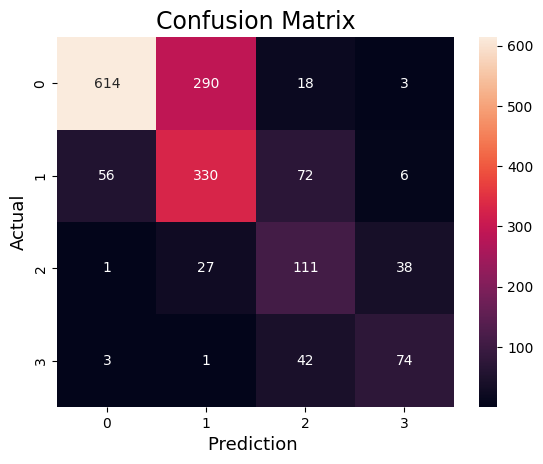

In [12]:
confusion_matrix(y_true,y_pred)